### Single-particle tracking pipeline for 2D data
Input: 
> Path to folder containing .tif time stacks of ROIs around labeled loci
> 
Output:  
 >   1. Localizations (trackpy)
>    2. Linked trajectories (trackpy)
>    3. MSD plots (trackpy)
>    4. Estimation of diffusion coefficient, anomolous exponent, and localization error
>

Dependencies:
> matplotlib, pandas, numpy \
> trackpy, scipy, scikit-image, seaborn
>

*Note: it seems like when fitting the MSD with noise, localization precision may not be acurate. In the future, it might be better to calculate the average localization precision for each trajectory and pass this to the equation instead of fitting. That said, the estimated D and alpha are comparable between fitting the noise and not.*

#### Load all packages

In [110]:
#%matplotlib inlinet
import matplotlib.pyplot as plt, pandas as pd, numpy as np, os     # general packages
from matplotlib.lines import Line2D
import warnings

# trackpy for tracking, scipy for MSD fits
import trackpy as tp
tp.ignore_logging()

# packages for image io, curve fitting, and plotting
from scipy.optimize import curve_fit
import skimage as sk
import seaborn as sb


6.25% done
12.5% done
18.75% done
25.0% done
31.25% done
37.5% done
43.75% done
50.0% done
56.25% done
62.5% done
68.75% done
75.0% done
81.25% done
87.5% done
93.75% done
100.0% done
Means: 
D*            0.000678
alpha         0.388661
sigma         0.002227
D* x1000      0.678449
sigma x100    0.222661
dtype: float64
Standard Deviations: 
D*            0.000968
alpha         0.108371
sigma         0.003352
D* x1000      0.968039
sigma x100    0.335189
dtype: float64


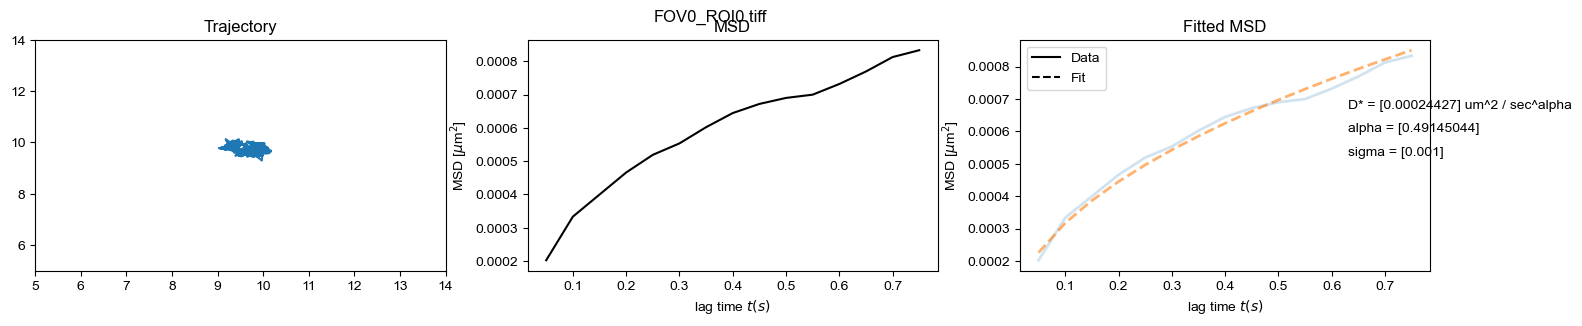

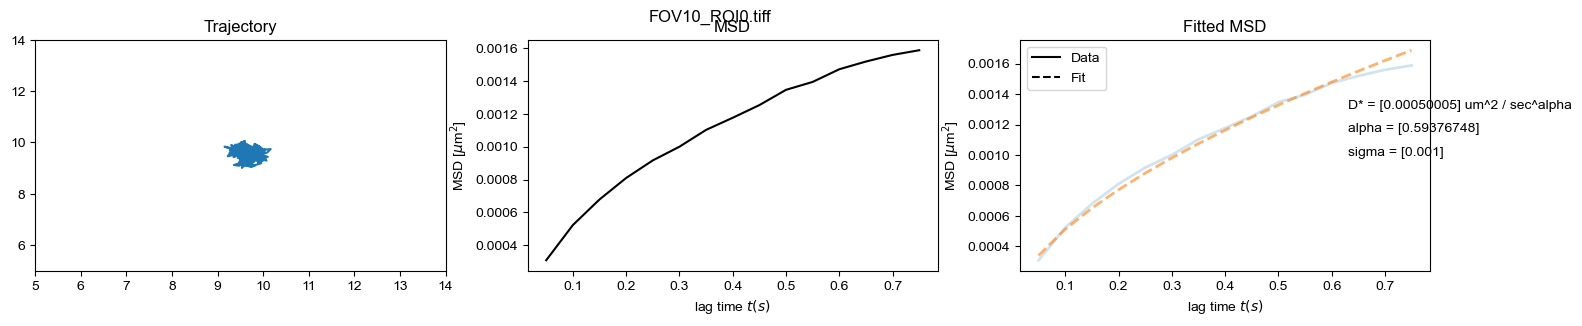

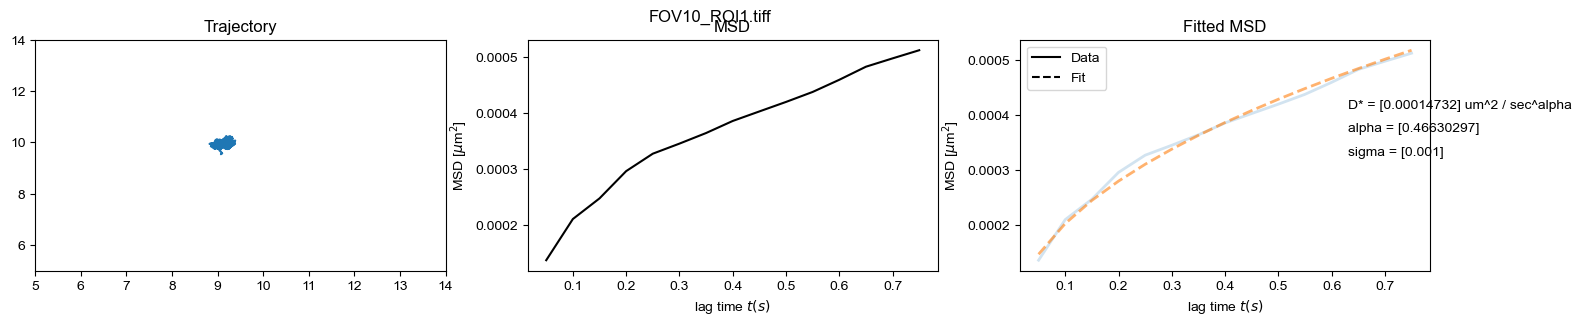

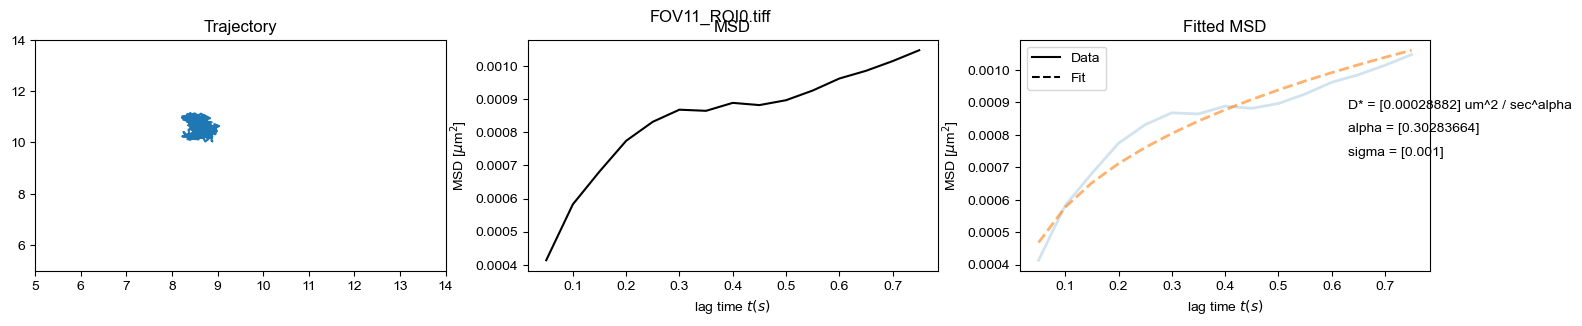

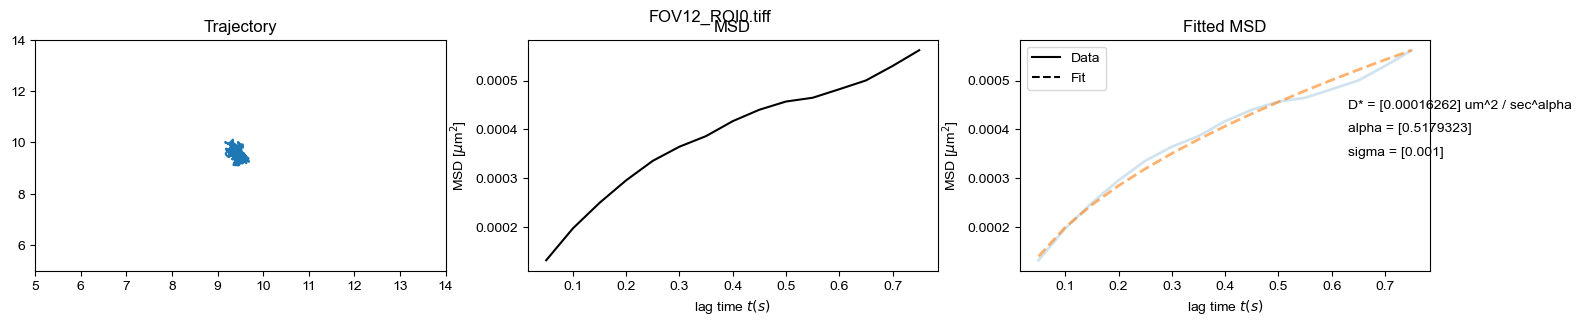

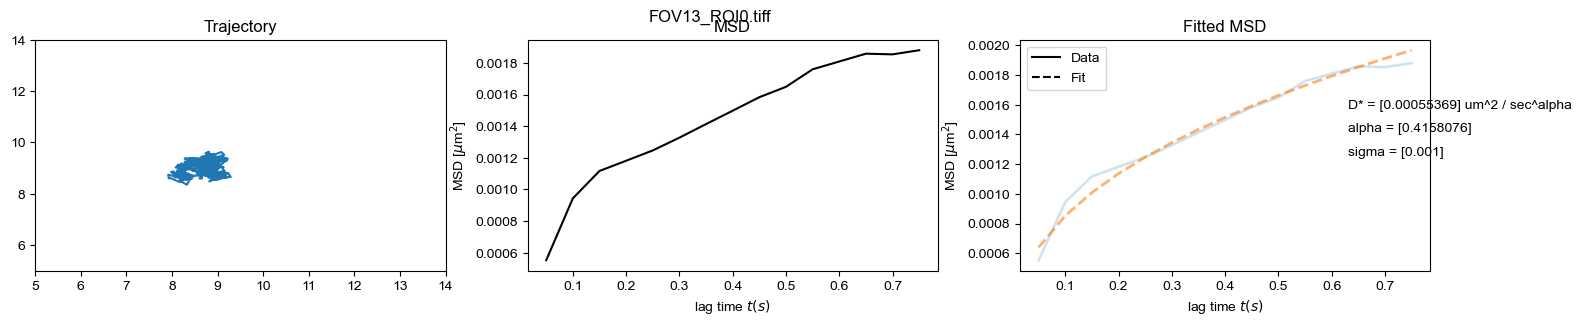

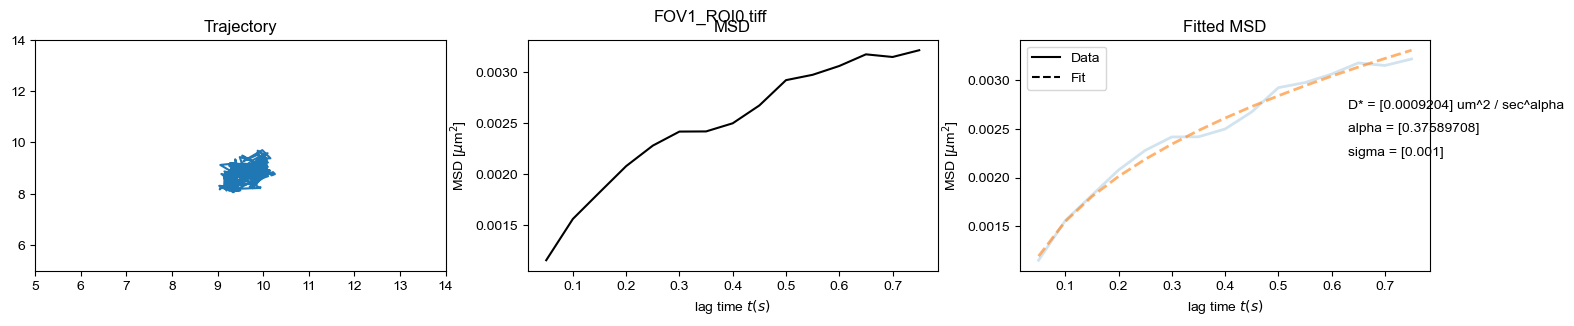

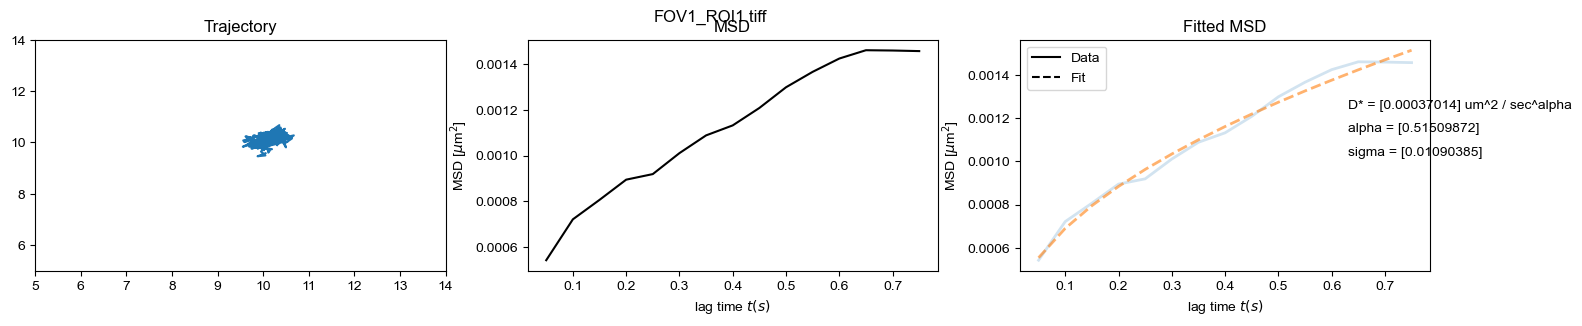

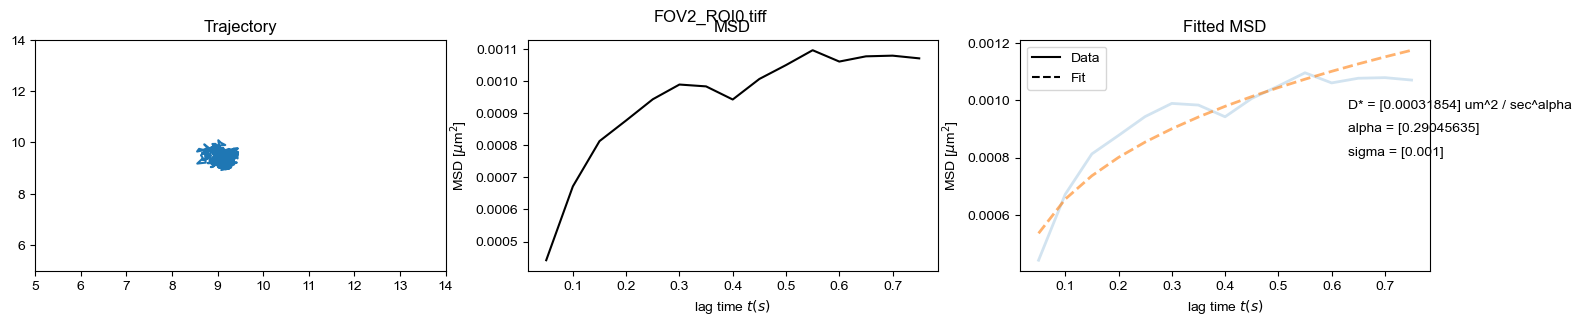

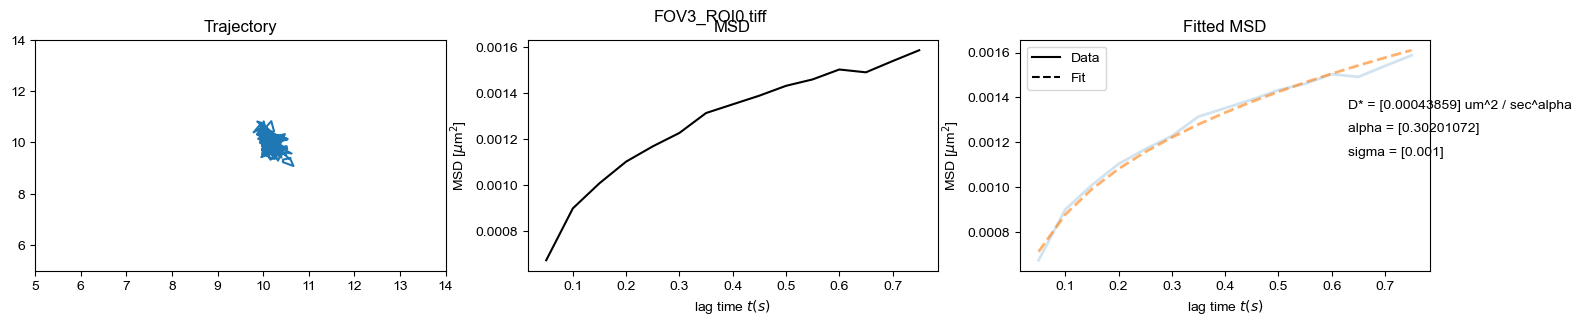

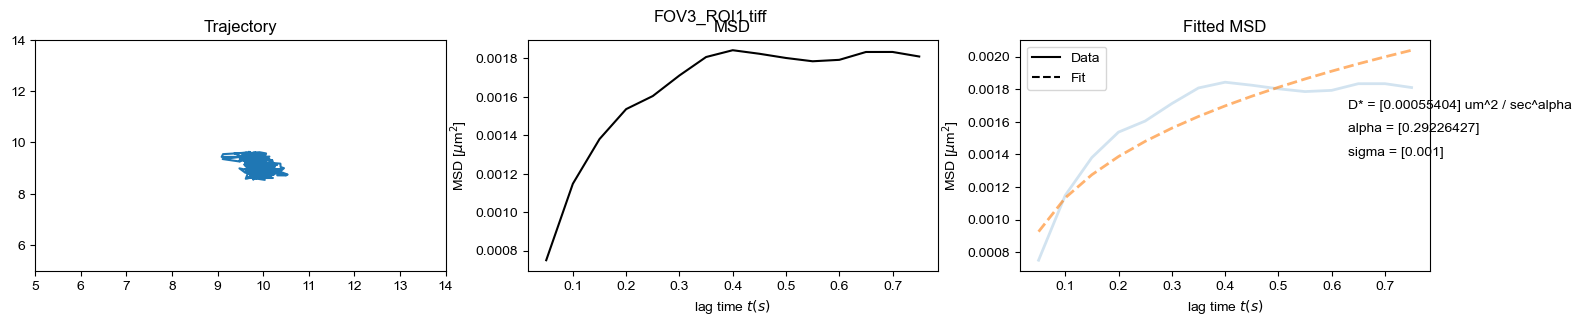

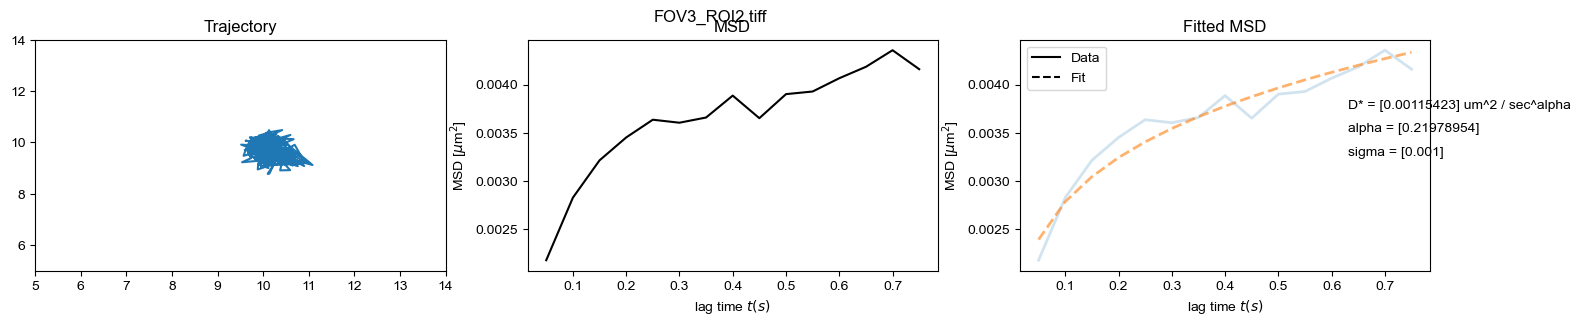

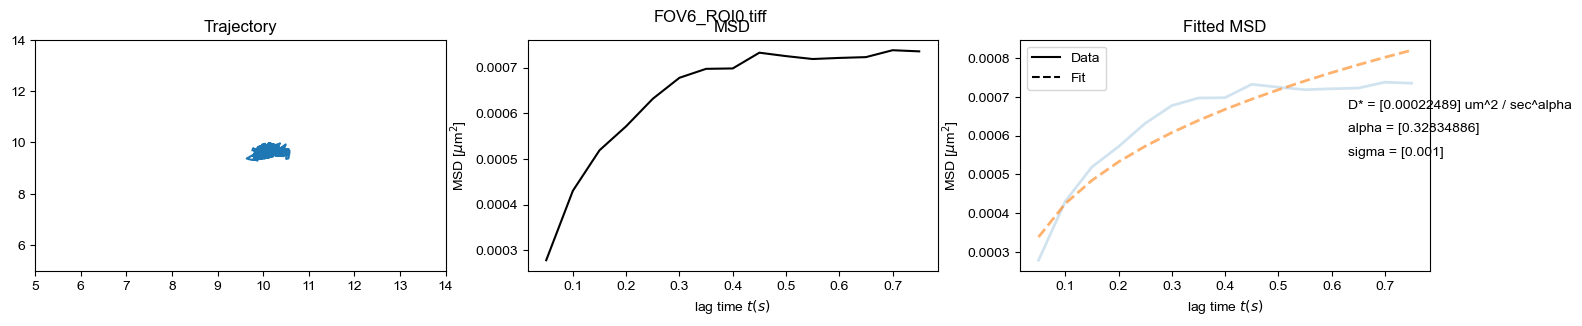

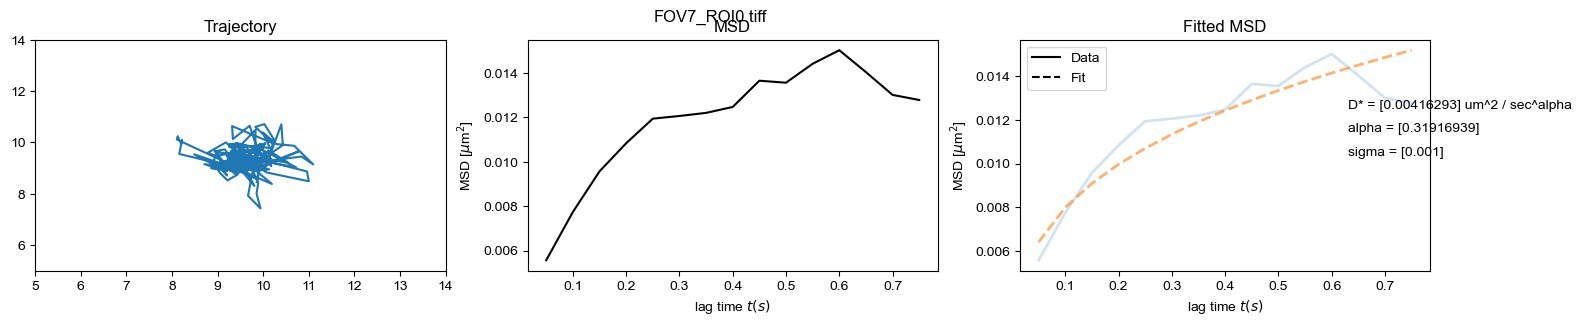

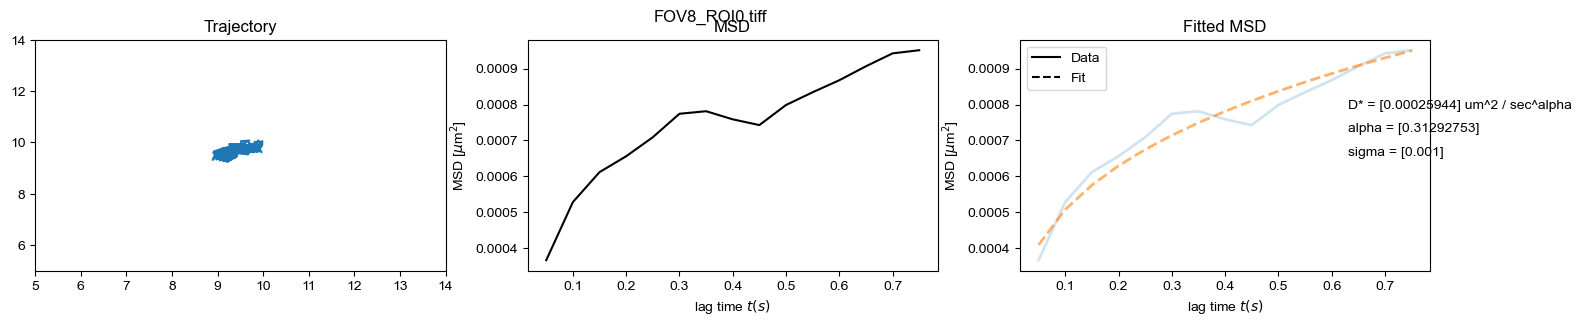

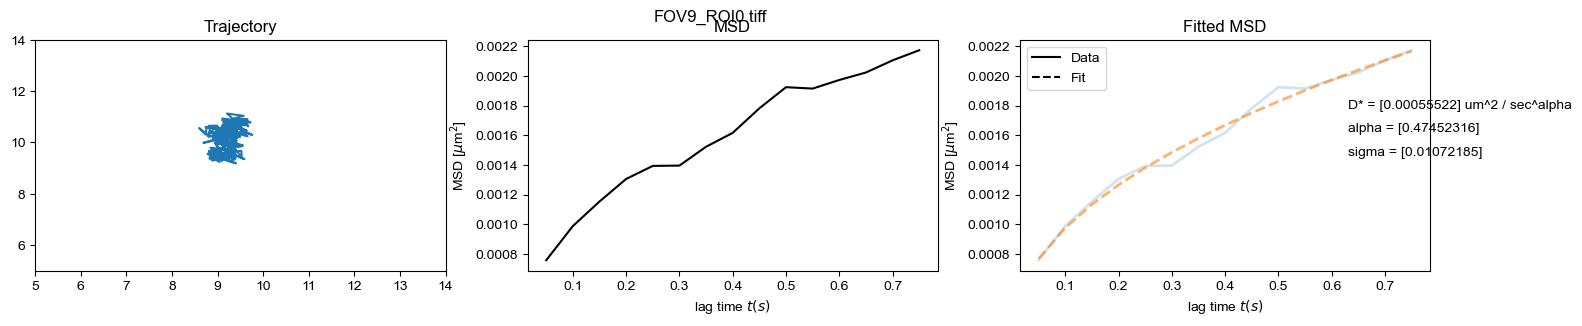

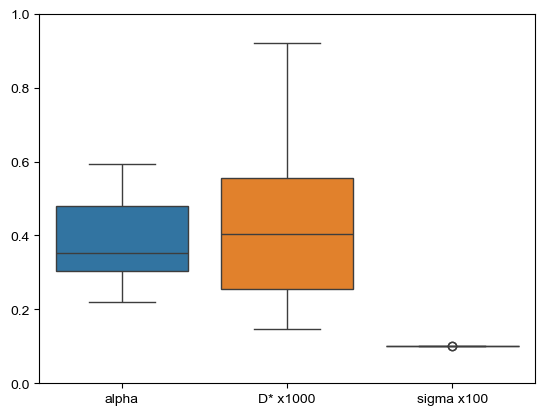

In [118]:
roi_directory = 'C:\\Users\\exyra\\OneDrive - Rice University\\Desktop\\Rice\\Gustavsson\\Codes\\chromtrack\\uf_roi\\'
df = track_all(roi_directory)
plot_boxes(df)

In [108]:
def msd_2D(lag, D_eff,  alpha, sigma=0.003):
    #t_exp = 0.05
    return ((4*D_eff*np.power(lag,alpha)) + 2*np.power(sigma,2))

def msd_2D_log(lag, D_eff,  alpha, sigma=0.003):
    #t_exp = 0.05
    return np.log((4*D_eff*np.power(lag,alpha)) + 2*np.power(sigma,2))

def fit_msd(im):
    fits = pd.DataFrame()
    fits.index = im.index
    xdata = im.index.to_numpy() 
    bounds=([0.00001, 0.01], [0.1, 2.])
    p0 = [0.0005,0.5]
    params = pd.DataFrame()
    params.index = ['D*', 'alpha']
    for i in im.columns:   
        popt, pcov = curve_fit(msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
        fits['Fit of ' + str(i)] = msd_2D(xdata,*popt)
        params[i] = popt

    return fits, params.T

def fit_msd_noise(im):
    fits = pd.DataFrame()
    fits.index = im.index
    xdata = im.index.to_numpy() 
    bounds=([0.00001, 0.01, 0.001], [0.1, 2., 1.0])
    p0 = [0.0005,0.5,0.003]
    params = pd.DataFrame()
    params.index = ['D*', 'alpha', 'sigma']
    for i in im.columns:   
        popt, pcov = curve_fit(msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
        fits['Fit of ' + str(i)] = msd_2D(xdata,*popt)
        params[i] = popt

    return fits, params.T

def trackroi(dir,file, spot_size=7, search_range=2, memory=3, mpp=0.13, fps=20, maxlag=15, min_track = 100):
    img = sk.io.imread(dir+file)
    locs = tp.batch(img, spot_size, topn = 1, preprocess = True)
    #locs = tp.refine_leastsq(rough_locs, img, spot_size, fit_function='gauss')

    
    traj = tp.link_df(locs, search_range, memory = memory, link_strategy = 'auto')      # trackpy links with the Crocker & Grier algorithm
    traj = tp.filter_stubs(traj, min_track)
    if len(traj['x']) > 0:
        im = tp.imsd(traj, mpp, fps, max_lagtime = maxlag)
    else: 
        im = pd.DataFrame()

    fitmsd, params = fit_msd_noise(im)

    fig = plt.figure(figsize=(18,3))

    #Set the font in the graph.
    plt.rcParams["font.family"] = "Arial"
        
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)  
    ax3 = fig.add_subplot(133) 

    #print(traj)
    ax1.set_title('Trajectory')
    ax1.plot(traj['x'], traj['y'])
    ax1.set_xlim((5,14))
    ax1.set_ylim((5,14))

    
    

    ax2.plot(im.index, im, 'k-')  # black lines, semitransparent
    ax2.set(ylabel=r'MSD [$\mu$m$^2$]', xlabel='lag time $t (s)$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title('MSD')


    ax3.plot(im.index,im, linestyle = '-',alpha = 0.2, linewidth = 2)
    warnings.filterwarnings('ignore')
    ax3.plot(fitmsd.index, fitmsd, linestyle = '--',alpha = 0.6, linewidth = 2)
    warnings.filterwarnings('ignore')
    ax3.set(ylabel=r'MSD [$\mu$m$^2$]', xlabel='lag time $t (s)$')
    ax3.set_yscale('linear')
    ax3.set_xscale('linear')
    ax3.set_title('Fitted MSD')
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
    linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
    ax3.legend(handles=[lined, linef])
    ax3.text(0.8,
         0.7,
         "D* = {} um^2 / sec^alpha".format(params['D*'].values),
         transform=plt.gca().transAxes)

    ax3.text(0.8,
         0.6,
         "alpha = {} ".format(params['alpha'].values),
         transform=plt.gca().transAxes)

    ax3.text(0.8,
         0.5,
         "sigma = {} ".format(params['sigma'].values),
         transform=plt.gca().transAxes)

    #plt.show()
    plt.suptitle(file)
    return params

In [112]:
def track_all(roi_directory):
    directory = os.fsencode(roi_directory)
    count = 1
    all_tracks = pd.DataFrame()
    for file in os.listdir(directory):
        
        filename = os.fsdecode(file)
        perc = count / len(os.listdir(directory))
        
        if filename.endswith(".tiff"): 
            all_tracks = pd.concat([all_tracks, trackroi(roi_directory,filename)])
    
        print(str(perc*100) + "% done")
        count = count + 1

    return all_tracks
    

In [117]:
def plot_boxes(all_tracks):
    all_tracks['D* x1000'] = all_tracks['D*']*1000
    all_tracks['sigma x100'] = all_tracks['sigma'] * 100
    print('Means: ')
    print(all_tracks.mean(axis=0))
    print('Standard Deviations: ')
    print(all_tracks.std(axis=0))
    plt.figure()
    g = sb.boxplot(data=all_tracks[['alpha','D* x1000','sigma x100']])
    g.set_ylim((0,1.0))